In [16]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import os

import sys
sys.path.append('../utils')
from nsl_wavelet_utils import *

In [30]:
fs = 128
n_freqs = 128
frequencies = wavelet_freqs(fs, n_freqs)
"""ft_l_nmus_pre = loadmat('./matlab_powerdata/y_listen_nmus_pre_power.mat')['y_power']
ft_m_nmus_pre = loadmat('./matlab_powerdata/y_motor_nmus_pre_power.mat') ['y_power']
ft_e_nmus_pre = loadmat('./matlab_powerdata/y_error_nmus_pre_power.mat') ['y_power']"""


In [43]:

# Define the directory and file pattern
directory = './matlab_powerdata/'
files = [f for f in os.listdir(directory) if f.endswith('.mat')]

# Create a dictionary to store the loaded data
power_dict = {}

# Load the data dynamically
for file in files:
    # Extract the label from the file name
    label = f'ft_{file.split('_')[1]}_{file.split('_')[2]}_{file.split('_')[3]}'
    power_dict[label] = loadmat(os.path.join(directory, file))['y_power']

In [46]:
power_dict.keys()

dict_keys(['ft_listen_nmus_post', 'ft_error_mus_pre', 'ft_error_nmus_pre', 'ft_listen_nmus_pre', 'ft_error_mus_post', 'ft_error_nmus_post', 'ft_listen_mus_post', 'ft_motor_mus_post', 'ft_motor_nmus_post', 'ft_motor_mus_pre', 'ft_motor_nmus_pre', 'ft_listen_mus_pre'])

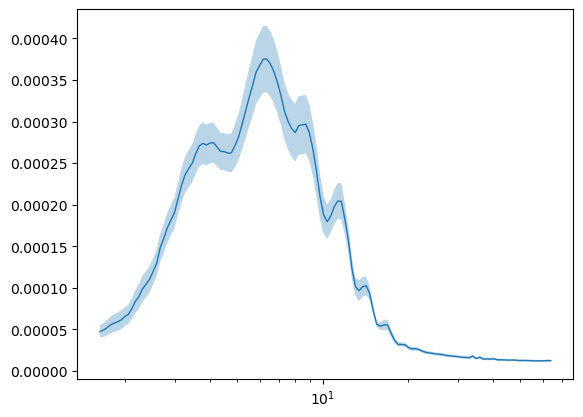

In [22]:
plt.xscale('log')

# Calculate the mean and SEM
mean_power = np.mean(ft_l_nmus_pre, axis=0)
sem_power = np.std(ft_l_nmus_pre, axis=0) / np.sqrt(ft_l_nmus_pre.shape[0])

# Plot the mean line
plt.plot(frequencies, mean_power, linewidth=1)

# Fill the area between the mean ± SEM
plt.fill_between(frequencies, mean_power - sem_power, mean_power + sem_power, alpha=0.3)


(0.0, 0.0005)

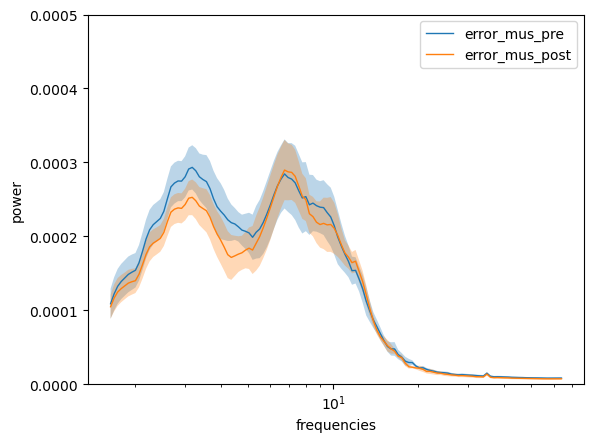

In [72]:

#groups = ['listen_nmus_post', 'motor_nmus_post', 'error_nmus_post']
groups = ['error_mus_pre', 'error_mus_post']

for i, group in enumerate(groups):
    power_data = power_dict[f'ft_{group}']

    mean_power = np.mean(power_data, axis=0)
    sem_power = np.std(power_data, axis=0) / np.sqrt(power_data.shape[0])

    plt.plot(frequencies, mean_power, label = groups[i],linewidth=1)
    plt.fill_between(frequencies, mean_power - sem_power, mean_power + sem_power, alpha=0.3)

plt.xscale('log')
plt.xlabel('frequencies')
plt.ylabel('power')
plt.legend()
plt.ylim(0, 5e-4)